# Navier-Stokes chanel with obstacle

We want to solve the Navier-Stokes incompressible equations along a 2D channel. 

The equations are:

$$
\rho(\partial_t u_i + u^j\partial_j u_i) = \partial^j \sigma_{ij}(u,p) + f_i
$$

where,

$$\sigma_{ij} := 2\mu \epsilon_{ij} - e_{ij}p \;\;\;\;\;\;\;\; \epsilon_{ij} = \partial_{(i} u_{j)}$$,

$$\partial^i u_i = 0$$

As boundary condition we shall say that along the chanel there are non-slip boundary conditions ($u=0$).
At the left entrance of the chanel there will be given a velocity and at the end an outflow condition we shall take as the boundary condition that the velocity has vanishing derivative along the chanel and that the pressure there vanish. (at least this seems to be the condition imposed in the code)

In [1]:
"""This demo program solves the incompressible Navier-Stokes equations
on an L-shaped domain using Chorin's splitting method."""

# Is is based in: 
#
# Copyright (C) 2010-2011 Anders Logg
#
# This file is part of DOLFIN.
#
# DOLFIN is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# DOLFIN is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU Lesser General Public License for more details.
#
# You should have received a copy of the GNU Lesser General Public License
# along with DOLFIN. If not, see <http://www.gnu.org/licenses/>.
#
# Modified by Mikael Mortensen 2011
#
# First added:  2010-08-30
# Last changed: 2011-06-30
#
# Modified by Oscar Reula

# Begin demo

%matplotlib inline
import matplotlib.pyplot as plt
from dolfin import *
from mshr import *

# Print log messages only from the root process in parallel
parameters["std_out_all_processes"] = False;

We set the evolution parameters:

In [2]:
#some cases:

case0 = False # the chanel without obstacle
case1 = False # this is more general than 2, but seems to be slow. This also gives incomming boundary condition for the pressure.
case2 = True # this gives a velocity field for incomming condition.
case3 = False # jet

In [3]:
# Set parameter values
#dt = 0.005
#T = 3.0 #3
#nu = 0.01

T = 6.0            # final time
#num_steps = 6000   # number of time steps for 128 T=3 case2
num_steps = 12000   # number of time steps for 128 T=6 case2
#num_steps = 3000   # number of time steps for 64 T=3 case3
#num_steps = 6000   # number of time steps for 64 T=6 case3
dt = T / num_steps # time step size

# dynamic viscosity
if case0:
    mu =1.
elif case3:
    mu = 0.001
else:
    mu = 0.001
rho = 1    

Create the meshes and plot them:

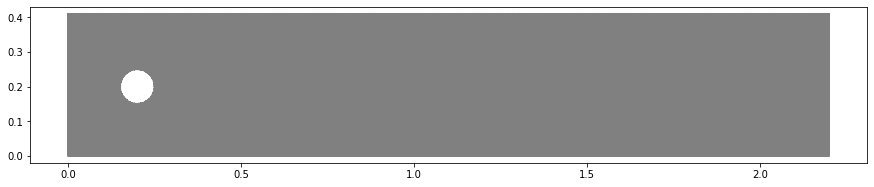

In [4]:
# Load mesh from file
#mesh = Mesh("../lshape.xml.gz")
# Create mesh

if case0:
    length = 1.
    width = 1.
    
    channel = Rectangle(Point(0, 0), Point(length, width))
    domain = channel
    
elif case3:
    length = 2.
    width = 1.
    
    mesh = RectangleMesh(Point(0, 0), Point(length, width), 256, 256);
    #channel = Rectangle(Point(0, 0), Point(length, width))
    #domain = channel
    
else:
    length = 2.2
    width = 0.41
    center_x = 0.2
    center_y = 0.2 #width / 2.
    radious = 0.05 #width / 4.
    
    channel = Rectangle(Point(0, 0), Point(length, width))
    cylinder = Circle(Point(center_x, center_y), radious)
    domain = channel - cylinder


mesh = generate_mesh(domain, 256)

# Plot mesh
plt.figure(figsize=(15,20))
plot(mesh)

We now create the function spaces, notice the difference between the function spaces for the velocity and pressure spaces, not only on the geometrical character but also on the degree. 

In [5]:
# Define function spaces (P2-P1)
V = VectorFunctionSpace(mesh, "Lagrange", 2)
Q = FunctionSpace(mesh, "Lagrange", 1)

# Define trial and test functions
u = TrialFunction(V)
p = TrialFunction(Q)
v = TestFunction(V)
q = TestFunction(Q)

# Define functions for solutions at previous and current time steps
u_n = Function(V)
u1  = Function(V)
p_n = Function(Q)
p1  = Function(Q)

Some expressions we shall use at the variational stage

In [6]:
# Define expressions used in variational forms
U  = 0.5*(u_n + u)
n  = FacetNormal(mesh)
f  = Constant((0, 0))
k  = Constant(dt)
mu = Constant(mu)
rho = Constant(rho)

In [7]:
# Define symmetric gradient
def epsilon(u):
    return sym(nabla_grad(u))

# Define stress tensor
def sigma(u, p):
    return 2*mu*epsilon(u) - p*Identity(len(u))

We are now in condition to set the boundaries.

In [8]:

tol = 1.E-4


if case0 or case3:
    
    # Define boundaries
    inflow   = 'near(x[0], 0)'
    if case0: 
        outflow  = 'near(x[0], 1.0)'
    if case3:
        outflow  = 'near(x[0], 2.0)'
    walls    = 'near(x[1], 0) || near(x[1], 1.0)'

    # Define inflow profile
    if case0:
        inflow_profile = ('4.0*x[1]*(1.0 - x[1])', '0.0')

    if case3: 
        inflow_profile = ('(x[1] < 0.45 || x[1] > 0.55)? 0.0: 1.0', '0.0')
        #inflow_profile = ('exp(-(x[1]-0.5)*(x[1]-0.5)*(x[1]-0.5)*(x[1]-0.5))', '0.0')
        #inflow_profile = ('4.0*x[1]*(1.0 - x[1])', '0.0')
        
    # Define boundary conditions
    bcu_inflow = DirichletBC(V, Expression(inflow_profile, degree=2), inflow)
    bcu_walls = DirichletBC(V, Constant((0, 0)), walls)
    bcp_outflow = DirichletBC(Q, Constant(0), outflow)
    bcp_inflow = DirichletBC(Q, Constant(8), inflow)
    bcu = [bcu_inflow, bcu_walls]
    bcp = [bcp_outflow]

if case1:

    # boundary_markers = FacetFunction('size_t', mesh)  # Esto fue actualizado
    boundary_markers = MeshFunction("size_t", mesh, mesh.topology().dim()-1, 0)


    class outer_top_botom(SubDomain):
        def inside(self, x, on_boundary):
            return  on_boundary and near(x[1], 0, tol) or near(x[1],width, tol) 
    outer_tb = outer_top_botom()
    outer_tb.mark(boundary_markers, 0)

    class outer_left(SubDomain):
        def inside(self, x, on_boundary):
            return  on_boundary and near(x[0], 0, tol) 
    outer_l = outer_left()
    outer_l.mark(boundary_markers, 1)

    class outer_right(SubDomain):
        def inside(self, x, on_boundary):
            return  on_boundary and near(x[0], length, tol) 
    outer_r = outer_right()
    outer_r.mark(boundary_markers, 2)

    class cyl(SubDomain):
        def inside(self, x, on_boundary):
            #return  on_boundary and near((x[0]-center_x)**2 + (x[1]-center_y)**2, radious**2, tol) 
            return  on_boundary and (x[0] > (center_x - radious - tol)) and (x[0] < (center_x + radious + tol))\
            and  (x[1] > (center_y - radious - tol)) and  (x[1] < (center_y + radious + tol))
    cyl = cyl()
    cyl.mark(boundary_markers, 3)
    
    # Define time-dependent pressure boundary condition
    #p_in = Expression("sin(3.0*t)", t=0.0, degree=2)
    p_in = Constant(1.)
    
    # Define inflow profile
    inflow_profile = ('4.0*1.5*x[1]*(0.41 - x[1]) / pow(0.41, 2)', '0')

    # Define boundary conditions
    noslip  = DirichletBC(V, (0, 0), outer_tb)
    bcp_inflow  = DirichletBC(Q, p_in, outer_l)
    bcu_inflow  = DirichletBC(V, Expression(inflow_profile, degree=2), outer_l)
    bcp_outflow = DirichletBC(Q, Constant(0), outer_r)
    noslip_cyl = DirichletBC(V, (0, 0), cyl)
    bcu = [noslip, noslip_cyl, bcu_inflow]
    bcp = [bcp_inflow, bcp_outflow]

    
if case2:
    # Define boundaries
    inflow   = 'near(x[0], 0)'
    outflow  = 'near(x[0], 2.2)'
    walls    = 'near(x[1], 0) || near(x[1], 0.41)'
    cylinder = 'on_boundary && x[0]>0.1 && x[0]<0.3 && x[1]>0.1 && x[1]<0.3'

    # Define inflow profile
    inflow_profile = ('4.0*1.5*x[1]*(0.41 - x[1]) / pow(0.41, 2)', '0')

    # Define boundary conditions
    bcu_inflow = DirichletBC(V, Expression(inflow_profile, degree=2), inflow)
    bcu_walls = DirichletBC(V, Constant((0, 0)), walls)
    bcu_cylinder = DirichletBC(V, Constant((0, 0)), cylinder)
    bcp_outflow = DirichletBC(Q, Constant(0), outflow)
    bcu = [bcu_inflow, bcu_walls, bcu_cylinder]
    bcp = [bcp_outflow]



The first step it to solve for $u^{\star}$, a first approximation to the value of $u$ at $t+dt$:

$$ < \rho(u^{\star} - u^n)/dt, v>_{\Omega} + <\rho u^n \cdot \nabla u^n, v>_{\Omega} + <\sigma(u^{n+\frac12},p^n), \epsilon(v)>_{\Omega} + <p^n n, v>_{\partial\Omega} - <\mu \nabla(u^{n+\frac12})\cdot n, v>_{\partial\Omega} = <f^n,v>_{\Omega},
$$

where $u^{n+\frac12} := \frac12(u^n + u^{\star})$

In [9]:
# Define variational problem for step 1
F1 = rho*dot((u - u_n) / k, v)*dx \
   + rho*dot(dot(u_n, nabla_grad(u_n)), v)*dx \
   + inner(sigma(U, p_n), epsilon(v))*dx \
   + dot(p_n*n, v)*ds - dot(mu*nabla_grad(U)*n, v)*ds \
   - dot(f, v)*dx
a1 = lhs(F1)
L1 = rhs(F1)

Next we find $p$ so that the time derivative of $u$ is divergence free:

In [10]:
# Define variational problem for step 2
a2 = dot(nabla_grad(p), nabla_grad(q))*dx
L2 = dot(nabla_grad(p_n), nabla_grad(q))*dx - (1/k)*div(u1)*q*dx

Finally we correct the value of $u$ with new energy:

In [11]:
# Define variational problem for step 3
a3 = dot(u, v)*dx
L3 = dot(u1, v)*dx - k*dot(nabla_grad(p1 - p_n), v)*dx

Here we assemble all the numerical matrices in the appropriate format and apply boundary conditions.

In [12]:
# Assemble matrices
A1 = assemble(a1)
A2 = assemble(a2)
A3 = assemble(a3)

# Apply boundary conditions to matrices
[bc.apply(A1) for bc in bcu]
[bc.apply(A2) for bc in bcp]

[None]

We choose the solver for the matrix inversion:

In [13]:
# Use amg preconditioner if available
prec = "amg" if has_krylov_solver_preconditioner("amg") else "default"

# Use nonzero guesses - essential for CG with non-symmetric BC
parameters['krylov_solver']['nonzero_initial_guess'] = True

In [14]:
# Create files for storing solution
#ufile = File("results/velocity_64jet.pvd")
#pfile = File("results/pressure_64jet.pvd")
#vfile = File("results/vorticity_64jet.pvd")
#ufile = File("results/velocity_256jet_u.pvd")
#pfile = File("results/pressure_256jet_u.pvd")
#pfile = File("results/vorticity_256jet.pvd")

#ufile = File("results/velocity_64c.pvd")
#pfile = File("results/pressure_64c.pvd")
#pfile = File("results/vorticity_64cet.pvd")
#ufile = File("results/velocity_128c.pvd")
#pfile = File("results/pressure_128c.pvd")
#vfile = File("results/vorticity_128c.pvd")
ufile = File("results/velocity_256c.pvd")
pfile = File("results/pressure_256c.pvd")
vfile = File("results/vorticity_256c.pvd")

In [15]:
# Time-stepping


t = 0
for m in range(num_steps):

    # Update current time
    t += dt

    # Update pressure boundary condition
    if case1:
        p_in.t = t

    # Compute tentative velocity step
    b1 = assemble(L1)
    [bc.apply(A1, b1) for bc in bcu]
    solve(A1, u1.vector(), b1, "bicgstab", "default")

    # Pressure correction
    b2 = assemble(L2)
    [bc.apply(A2, b2) for bc in bcp]
    [bc.apply(p1.vector()) for bc in bcp]
    solve(A2, p1.vector(), b2, "bicgstab", prec)

    # Velocity correction
    b3 = assemble(L3)
    [bc.apply(A3, b3) for bc in bcu]
    solve(A3, u1.vector(), b3, "bicgstab", "default")

    # Save to file
        
#    if (m%30==0): # for 64
#    if (m%60==0): # for 128
    if (m%120==0): # for 128 T=6
        
        ufile << u1
        pfile << p1



    # Move to next time step
    u_n.assign(u1)


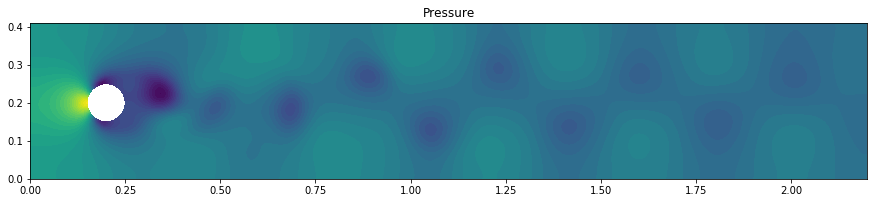

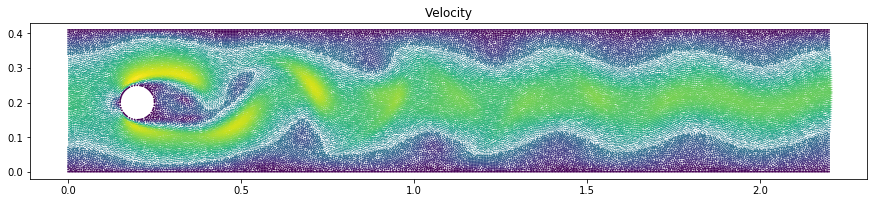

In [16]:
# Plot solution
plt.figure(figsize=(15,20))
plot(p1, title="Pressure")

plt.figure(figsize=(15,20))
plot(u1, title="Velocity")
#plot(mesh)

#plt.show()

#ufile.close()
#pfile.close()

In [17]:
vor = Function(Q)
vor = curl(u1)

fig_vor = plt.figure(figsize=(15,20))
fig_vor.colorbar(Vor, shrink=0.5, aspect=1)
#fig_vor.pcolor(Vor, cmap='RdBu',vmin = -10, vmax = 10)

Vor = plot(vor, title="Vorticity")

vfile << project(vor,Q)

#plot(mesh)


#b = project(curl(u_n),V)

NameError: name 'Vor' is not defined

<Figure size 1080x1440 with 0 Axes>